# Integrations Seminar Project

### Import all neccessary libraries

In [386]:
import requests
import random
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime
import time

    Initialization of the Dataframe with columns for scrapable data

In [ ]:
data = {'Bewohner': [], 'Eintrag': [], 'Miete': [], 'Groese': [] , 'Stadtteil': [], 'frei ab': [], 'frei bis': []}
df = pd.DataFrame(data=data)
print(df ,len(df))


    Setup of proxie and user-agent caroussel. These will be rotated between requests to avoid bot-detection

In [4]:
proxies = [
    'http://24.106.221.230:53281',
    'http://118.70.12.171:53281',
    'http://198.199.86.11:8080',
    'http://107.173.80.140:9000',
    'http://159.203.61.169:8080',
    'http://134.209.29.120:3128',
    'http://192.140.42.83:31511',
    'http://20.187.77.5:80',
    'http://64.225.8.191:9986',
    'http://198.59.191.234:8080',
    'http://51.178.47.12:80',
    'http://82.180.163.163:80',
    'http://158.69.72.138:9300',
    'http://198.49.68.80:80',
    'http://51.15.192.229:8080',
    'http://161.35.70.249:8080',
    'http://143.110.232.177:80',
    'http://154.118.228.212:80',
    'http://177.87.144.122:5566',
    'http://200.25.254.193:54240',
    'http://82.180.163.163:80'
    ]
userAgents = [
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
]

    Request and scrape functions

    makeRequest: takes URL and makes request using randomly picked proxy and user-agent
    scrapeTable: takes in the tbody element of the page, extracts datapoints through getters and adds data to the dataframe

In [414]:
def makeRequest(url):
    try:
        randomNum = random.randint(0, len(proxies) - 1)
        proxy = {proxies[randomNum][0 : 4] : proxies[randomNum]} # dict {http/s : IP-Address}
        userAgent = userAgents[random.randint(0, len(userAgents) -1)]
        print('Current Proxy: ', proxy, 'Current User-Agent: ', userAgent)
        
        return requests.get(url,
                            proxies=proxy,
                            headers={'User-Agent' : userAgent},
                            timeout=5)
    except:
        print("PROBLEM WHILE MAKING REQUEST")

def scrapeTable(tbody) -> None:
    data = []
    rows = tbody.findAll('tr')
    for row in rows:
        data.append(getFlatmates(row))
        data.append(getDatePosted(row))
        data.append(getPrice(row))
        data.append(getRoomSize(row))
        data.append(getNeighborhood(row))
        data.append(getMoveInDate(row))
        data.append(getMoveOutDate(row))
        
        df.loc[len(df) + 4] = data
        data.clear()
    
def getFlatmates(row):
    flatMatesDict = row.findAll('td')[1].span.attrs
    return flatMatesDict.get('title')

def getDatePosted(row):
    return row.findAll('td')[2].span.text.strip()

def getPrice(row):
    return row.findAll('td')[3].b.text.strip()

def getRoomSize(row):
    return row.findAll('td')[4].span.text.strip()

def getNeighborhood(row):
    return  row.findAll('td')[5].span.text

def getMoveInDate(row):
    return  row.findAll('td')[6].span.text.strip()

def getMoveOutDate(row):
    date = row.findAll('td')[7].a
    if date.find('span'):
        return date.find('span').text.strip()
    
    return ""

    Loop through wg-gesucht pagination and scrape the tbody element on each page

In [417]:
for i in range(440, 600):
    print(f'Page: {i}', end=' ')
    res = makeRequest(f'https://www.wg-gesucht.de/wg-zimmer-in-Mannheim.85.0.0.{i}.html')
    try: 
        page = BeautifulSoup(res.content, 'html.parser')
        scrapeTable(page.findAll('tbody')[0])
    except Exception as ex:
        print(ex)
        print(page.prettify())
        break

Page: 440 Current Proxy:  {'http': 'http://118.70.12.171:53281'} Current User-Agent:  Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36
Page: 441 Current Proxy:  {'http': 'http://177.87.144.122:5566'} Current User-Agent:  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36
Page: 442 Current Proxy:  {'http': 'http://154.118.228.212:80'} Current User-Agent:  Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0
Page: 443 Current Proxy:  {'http': 'http://64.225.8.191:9986'} Current User-Agent:  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15
Page: 444 Current Proxy:  {'http': 'http://161.35.70.249:8080'} Current User-Agent:  Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36
Page: 445 Current Pr

In [464]:
# for i, val in enumerate(df['Bewohner']):
#     if df['Bewohner'][i] == 50:
#         df['Bewohner'][i] = np.NAN
#         print(df['Bewohner'][i])
#         #df['Bewohner'][i] = np.NAN

df.loc[df.Bewohner == 50, 'Bewohner'] = np.NAN

df = df.dropna()

In [441]:
print(df.head())
for i, val in enumerate(df['Bewohner']):
    df['Bewohner'][i] = np.nan if pd.isnull(val) else val

df.dropna()

df = df.drop(df[df.Groese == 'n.a.'].index)
print(len(df))

            Bewohner     Eintrag Miete Groese   
1  2er WG (0w,1m,0d)  17.05.2023  250€   15m²  \
2  2er WG (1w,0m,0d)  17.05.2023  565€   16m²   
3  5er WG (0w,4m,0d)  17.05.2023  510€   21m²   
4  4er WG (1w,2m,0d)  17.05.2023  520€   19m²   
5  4er WG (2w,1m,0d)  17.05.2023  470€   15m²   

                                           Stadtteil     frei ab    frei bis  
1  Mannheim\n                                    ...  01.06.2023  30.08.2023  
2  Mannheim\n                                    ...  01.06.2023              
3  Mannheim\n                                    ...  01.06.2023              
4  Mannheim\n                                    ...  01.06.2023              
5  Mannheim\n                                    ...  01.06.2023              
9617


In [465]:
df.to_excel('Test.xlsx')

    Clean and extract data into lists

In [477]:
rentPrice = df.iloc[:, 2].tolist()
roomSize = df.iloc[:, 3].tolist()
flatmates = df.iloc[:, 0].tolist()

for i, price in enumerate(rentPrice):
    rentPrice[i] = int(price[0:len(price) - 1])

for i, room in enumerate(roomSize):
    roomSize[i] = int(room[0: len(room) - 2])

for i, flat in enumerate(flatmates):
    endIndex = flat.find('er')
    if type(flat[0:endIndex]) == str:
        flatmates[i] = int(flat[0:endIndex])
        print(flatmates[i]) 
        #if type(flat[0:endIndex]) == str else 0

moveInDates = []
for i, date in enumerate(df.iloc[:, 5].tolist()):
    if date !='aktuell' and date != '':
        moveInDates.append(datetime.strptime(date, "%d.%m.%Y").date())
    else: 
        moveInDates.append(datetime.today().date())

males = []
females = []

malePercentage = []
femalePercentage = []
for i, el in enumerate(df.iloc[:, 0].tolist()):
    begin = el.find('(') + 1
    end = el.find(')')
    inhabitants = el[begin : end]

    femInhabitants = int(inhabitants[0: inhabitants.find('w')])
    maleInhabitants = int(inhabitants[inhabitants.find('w') + 2: inhabitants.find('m')])
    femPercent = femInhabitants / flatmates[i]
    malePercent = maleInhabitants / flatmates[i]

    males.append(maleInhabitants)
    females.append(femInhabitants)
    malePercentage.append(malePercent)
    femalePercentage.append(femPercent)

<class 'str'> True
2
<class 'str'> True
5
<class 'str'> True
4
<class 'str'> True
4
<class 'str'> True
4
<class 'str'> True
6
<class 'str'> True
14
<class 'str'> True
4
<class 'str'> True
2
<class 'str'> True
4
<class 'str'> True
3
<class 'str'> True
3
<class 'str'> True
3
<class 'str'> True
3
<class 'str'> True
2
<class 'str'> True
10
<class 'str'> True
10
<class 'str'> True
3
<class 'str'> True
4
<class 'str'> True
3
<class 'str'> True
2
<class 'str'> True
2
<class 'str'> True
4
<class 'str'> True
4
<class 'str'> True
3
<class 'str'> True
5
<class 'str'> True
5
<class 'str'> True
4
<class 'str'> True
2
<class 'str'> True
4
<class 'str'> True
3
<class 'str'> True
3
<class 'str'> True
2
<class 'str'> True
2
<class 'str'> True
4
<class 'str'> True
5
<class 'str'> True
3
<class 'str'> True
3
<class 'str'> True
4
<class 'str'> True
4
<class 'str'> True
4
<class 'str'> True
5
<class 'str'> True
2
<class 'str'> True
4
<class 'str'> True
3
<class 'str'> True
6
<class 'str'> True
4
<class 'st

In [478]:
timeToMoveIn = []
for i, date in enumerate(moveInDates):
    time = (date - datetime.today().date()).days if (date - datetime.today().date()).days >= 0 else 0
    timeToMoveIn.append(time)

In [479]:
df_copy = df.copy()

    Add cleaned data into new dataframe columns

In [480]:
df_copy['flatmates'] = flatmates
df_copy['time to move in'] = timeToMoveIn
df_copy['Male Inhabitants'] = males
df_copy['Female Inhabitants'] = females
df_copy['% Male Flatmates'] = malePercentage
df_copy['% Female Flatmates'] = femalePercentage


    export dataframe as excel sheet

In [481]:
df_copy.to_excel('WG_Mannheim.xlsx')

    Visualize data with scatter plots
    Complete correlation analysis 

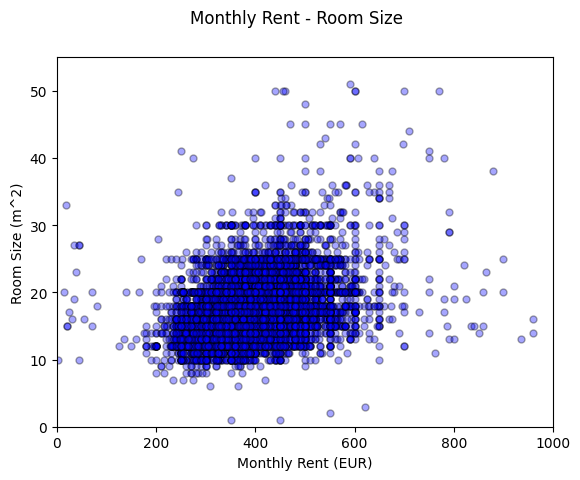

PearsonRResult(statistic=0.24066012761703043, pvalue=3.114799417200734e-126)

In [482]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Monthly Rent - Room Size")
#ax.grid()
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(0, 1000)
plt.ylim(0,55)
plt.xlabel('Monthly Rent (EUR)')
plt.ylabel('Room Size (m^2)')
plt.scatter(rentPrice, roomSize, s=25, c='blue',edgecolors='black', linewidths=1, alpha=0.35)
plt.show()

stats.pearsonr(rentPrice, roomSize)


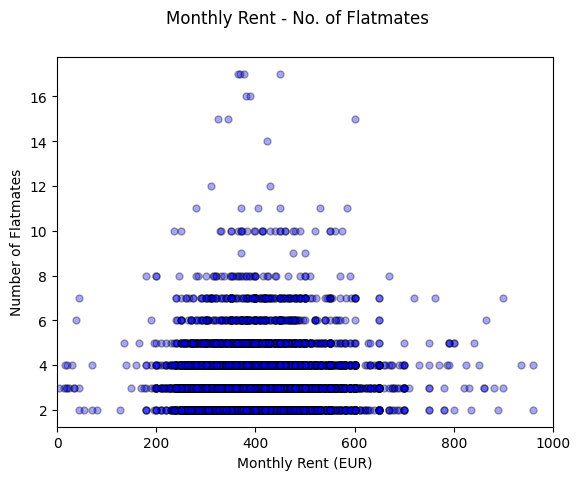

PearsonRResult(statistic=0.0071436155148851205, pvalue=0.4845703291229098)

In [483]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Monthly Rent - No. of Flatmates")
plt.xlabel('Monthly Rent (EUR)')
plt.ylabel('Number of Flatmates')
plt.xlim(0, 1000)

plt.scatter(rentPrice, flatmates, s=25, c='blue',edgecolors='black', linewidths=1, alpha=0.35)
plt.show()

stats.pearsonr(rentPrice, flatmates)

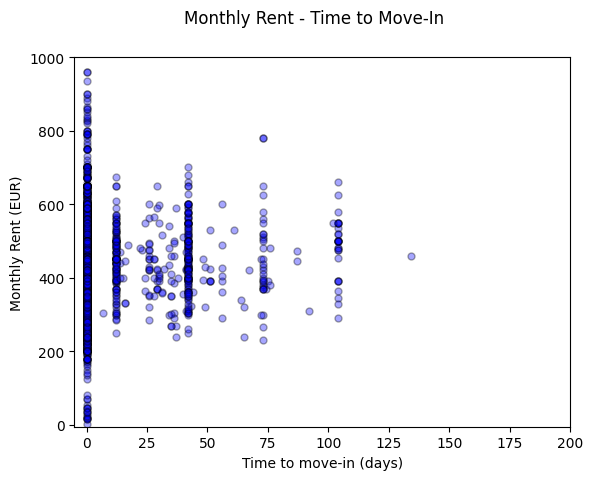

PearsonRResult(statistic=0.10466836579755298, pvalue=9.678834837262124e-25)

In [484]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Monthly Rent - Time to Move-In")
plt.xlabel('Time to move-in (days)')
plt.ylabel('Monthly Rent (EUR)')
plt.xlim(-5, 200)
plt.ylim(-5, 1000)
plt.scatter(timeToMoveIn, rentPrice, s=25, c='blue',edgecolors='black', linewidths=1, alpha=0.35)
plt.show()

stats.pearsonr(timeToMoveIn, rentPrice)

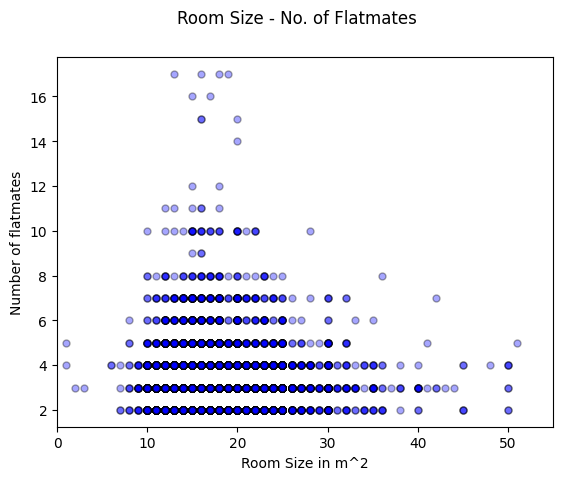

PearsonRResult(statistic=-0.00020877148073926433, pvalue=0.9837026719734189)

In [490]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Room Size - No. of Flatmates")
plt.ylabel('Number of flatmates')
plt.xlabel('Room Size in m^2')
#plt.yscale('log')
plt.xlim(0, 55)

plt.scatter(roomSize, flatmates, s=25, c='blue',edgecolors='black', linewidths=1, alpha=0.35)
plt.show()

stats.pearsonr(roomSize, flatmates)

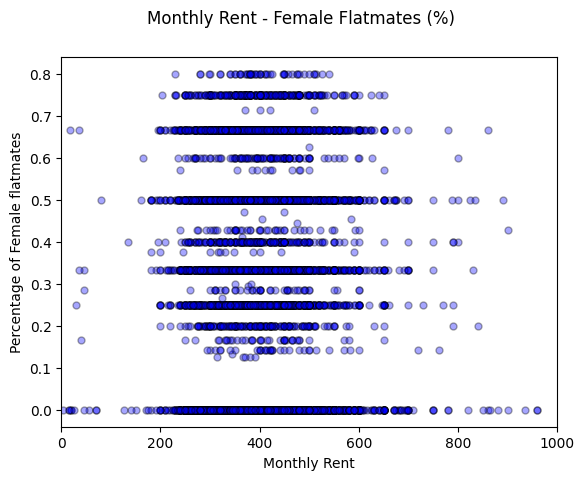

PearsonRResult(statistic=-0.0003670477961065996, pvalue=0.9713513132674471)

In [489]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Monthly Rent - Female Flatmates (%)")
plt.ylabel('Percentage of Female flatmates')
plt.xlabel('Monthly Rent')
plt.xlim(0,1000)
#plt.xscale('log')
#plt.yscale('log')

plt.scatter(rentPrice, femalePercentage, s=25, c='blue',edgecolors='black', linewidths=1, alpha=0.35)
plt.show()

stats.pearsonr(rentPrice, femalePercentage)

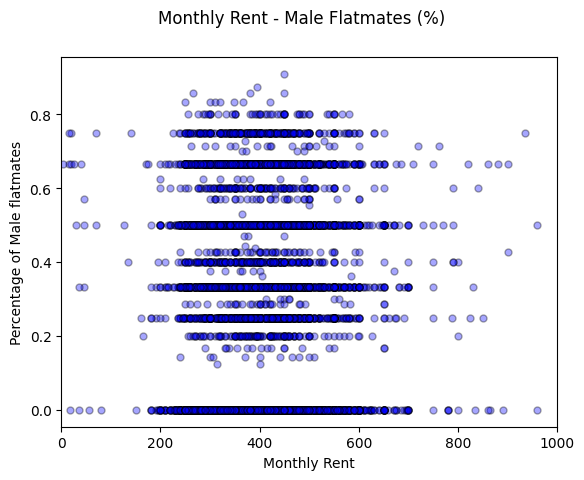

PearsonRResult(statistic=0.007463980693157277, pvalue=0.46519590760256374)

In [488]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Monthly Rent - Male Flatmates (%)")
plt.ylabel('Percentage of Male flatmates')
plt.xlabel('Monthly Rent')
plt.xlim(0,1000)
#plt.xscale('log')
#plt.yscale('log')

plt.scatter(rentPrice, malePercentage, s=25, c='blue',edgecolors='black', linewidths=1, alpha=0.35)
plt.show()

stats.pearsonr(rentPrice, malePercentage)